# NB1: MPR framework
-----

## module loading...

In [1]:
%matplotlib inline

import os, sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import xarray as xr
import pandas as pd

from timeit import default_timer as timer

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)
print(pd.__name__, pd.__version__)

sys.path.append('../')


The Python version: 3.7.0
xarray 0.16.2
pandas 1.2.1


In [2]:
# custom modules
from mpr import print_date
print_date()

from mpr.IO import load_geophysical_attributes, GEO_ATTR_TYPE
from mpr.IO import load_mapping_data
from mpr.IO import write_param

from mpr.scaling import horizontal_weighted_mean, vertical_weighted_mean

from mpr.model_layer import comp_layer_weight

Last executed: 2021-04-21 18:16:57.099878 by mizukami on crhtc41


In [3]:
xr.set_options(file_cache_maxsize=1000);

In [4]:
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=9, threads=4, memory="108GB",
#                  walltime='00:40:00')
#cluster.scale(jobs=3)

In [5]:
#from dask.distributed import Client
#client = Client(cluster)

In [6]:
#client

-------------------------
## Setup 

In [7]:
mpr_data_dir = '/glade/p/ral/hap/mizukami/pnw-extrems/geospatial_data/geophysical/data_mpr'

In [8]:
mapping_file = 'spatialweights_grid_600m_to_HUC12.nc'
mapping_vars = ['polyid', 'overlaps', 'weight', 'i_index', 'j_index', 'test']

In [9]:
soil_thickness  = [0.05, 0.1, 0.15, 0.3, 0.4, 1.0]
model_thickness = [0.1, 0.3, 0.6]

In [10]:
hru_meta  = {'name': 'hruId', 'dim':['hru'], 'long_name':'HRU ID'}
param_meta = {'theta_sat':          {'comp_order': 1, 'vertical_scale': True, 'horizontal_scale': True, 'dim': ['lyr', 'hru'], 'long_name':'Saturated hydraulic conductivity',  'units':'mm/s'},
              'heightCanopyTop':    {'comp_order': 2, 'vertical_scale': False, 'horizontal_scale': True, 'dim': ['hru'], 'long_name':'Canopy top height',  'units':'m'},
              'heightCanopyBottom': {'comp_order': 3, 'vertical_scale': False, 'horizontal_scale': True, 'dim': ['hru'], 'long_name':'Canopy bottom height',  'units':'m'}
             }

## 1. Load the data

### 1.1. geophysical attributes



In [11]:
# load all the geophysical attributes.
attr_data = load_geophysical_attributes()

loading geophysical attributes...


### 1.2. mapping weight

In [12]:
mapping_data = load_mapping_data(root=mpr_data_dir, file=mapping_file, var_list=mapping_vars)

loading mapping weight data...
Pre-process mapping data arrays


../mpr/IO.py:80: UserWarning: variable: "test" not exist
  warnings.warn('variable: "%s" not exist' % var)


## 2. Compute parameters 

In [13]:
param_native = {}

# temp transfer functions
kgm3_to_gcm3 = 0.001
param_native['theta_sat'] = 0.788 + 0.001*attr_data['clay_pct']- 0.263*attr_data['bulk_density']*kgm3_to_gcm3

In [14]:
param_native['heightCanopyTop'] = 0.75* attr_data['ch']
param_native['heightCanopyBottom'] = 0.50* param_native['heightCanopyTop']

## 3. Scaling parameters
1. layer mapping computation based on soil and model layer thickness
2. vertical scaling for soil layers
3. horizontal scaling for all the parameters

In [15]:
# compute layer mapping data
layer_weight = comp_layer_weight(soil_thickness, model_thickness)
layer_weight

{'overlaps': array([2, 3, 3], dtype=int32),
 'soil_index': array([[0, 1, 0],
        [1, 2, 3],
        [3, 4, 5]], dtype=int32),
 'weight': array([[0.5       , 0.5       , 0.        ],
        [0.16666667, 0.5       , 0.33333334],
        [0.33333334, 0.6666667 , 0.        ]], dtype=float32)}

In [16]:
%%time
param_model = {}
for param, meta in param_meta.items():
    par_array = param_native[param].values
    print(f'Scaling {param}')
    if meta['vertical_scale']:
        print('  vertical-scaling')
        par_array = vertical_weighted_mean(layer_weight, par_array, 1)
    print('  horizontal-scaling')
    param_model[param] = horizontal_weighted_mean(mapping_data, par_array, 1)

Scaling theta_sat
  vertical-scaling
  horizontal-scaling
Scaling heightCanopyTop
  horizontal-scaling
Scaling heightCanopyBottom
  horizontal-scaling
CPU times: user 1.69 s, sys: 702 ms, total: 2.39 s
Wall time: 2.41 s


## 4. Output final parameters

In [17]:
%%time
write_param(param_model, param_meta, mapping_data['polyid'], hru_meta, root='./', file='test.nc')

CPU times: user 5.58 ms, sys: 1.09 ms, total: 6.67 ms
Wall time: 69.9 ms


## 5. Check parameters

In [18]:
import geopandas as gpd
hru_shapefile = '/glade/p/ral/hap/mizukami/pnw-extrems/geospatial_data/PNW_HUC12_ext_v5_merit.trim2.gpkg'
df_hru = gpd.read_file(hru_shapefile)

# clean attributes
df_hru.drop(columns=['SourceData','SourceOrig','LoadDate','NonContr_1','HUMod','NonContrib','HUType','HUC12','pfaf150', 'AREA_GEO','PERIM_GEO','pfaf_merit'], inplace=True)
df_hru = df_hru.rename(columns={'HUCIDXint':'hruId'})
df_hru = df_hru.set_index('hruId')

In [ ]:
print(df_hru.head)

In [20]:
ds = xr.open_dataset('./test.nc')
ds = ds.assign_coords({'hru':ds['hruId']})

In [21]:
# merge xr dataset and shapefile
par_name = 'theta_sat'
lyr = 0
df = ds[par_name].to_dataframe().unstack(level=0)
df = df.droplevel(0, axis=1) 
df_plot = df_hru.merge(df,left_index=True, right_index=True)

In [22]:
for val in df_plot[lyr]:
    if val <0.2:
        print(val)

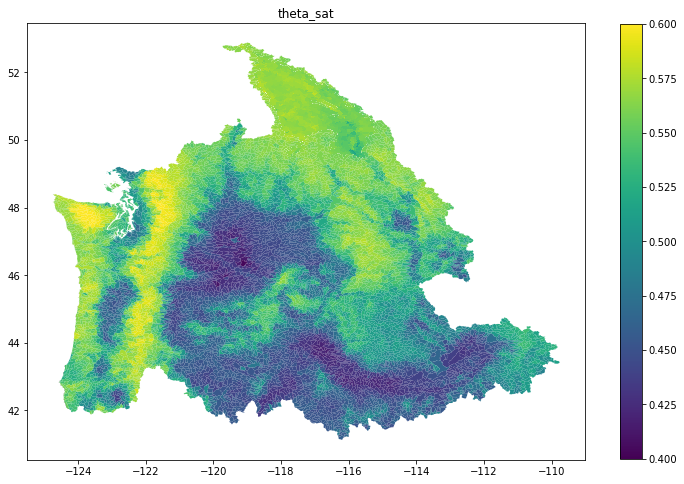

In [23]:
# model space
fig, ax = plt.subplots(1, figsize=(12.5, 10))
df_plot.plot(ax=ax, column=lyr, vmin=0.4, vmax=0.6, legend=True, legend_kwds={'shrink': 0.8});
ax.set_title(par_name);

#plt.savefig("mizuRoute_GF_output.png", dpi=200)

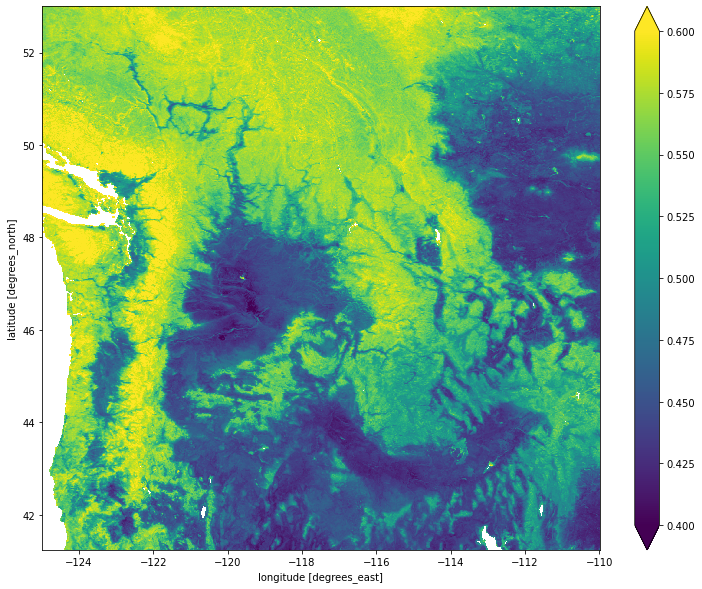

In [24]:
#native space
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(12.5, 10))
dr = param_native['theta_sat'][0:1,:,:].mean(axis=0)
dr.plot.pcolormesh(vmin=0.4, vmax=0.6);

##  Experiments

In [ ]:
FILL_VALUE = -9999.0

def horizontal_weighted_mean_test(mapping_data, origArrays, pvalue, default=FILL_VALUE):
    """ Brief: Compute areal weighted generalized mean value of for all target HRUs, given pvalue

        Details:
        input:  mapping_data, reformated mapping data,        dictionary {mapping variable name: numpy array}
                ogirArray,    fine resolution parameter grid, numpy array (2D or 3D see below)
                pvalue,       parameter in generalized mean operator
        return: wgtedVal,     remapped parameter array,

        ogirArray: 2D [lat, lon] -      -> wgtedVal: 1D [hru]
        ogirArray: 3D [Month, lat, lon] -> wgtedVal: 2D [Month, hru]
                      [lyr, lat, lon]   -> wgtedVal: 2D [lyr, hru]

    """
    # numpy broadcasting rule
    # https://numpy.org/doc/stable/user/basics.broadcasting.html

    array_shape = origArrays.shape
    nDims       = len(array_shape)

    # TODO
    # move these out of function
    nOutHRUs    = len(mapping_data['overlaps'])
    maxOverlaps = mapping_data['overlaps'].max()

    if nDims == 2:
        wgtedVals   = np.zeros((nOutHRUs), dtype='float32')
        matDataVals = np.zeros((nOutHRUs, maxOverlaps), dtype='float32')
    elif nDims == 3:
        wgtedVals   = np.zeros((array_shape[0], nOutHRUs), dtype='float32')
        matDataVals = np.zeros((array_shape[0], nOutHRUs, maxOverlaps), dtype='float32')
    else:
        pass # add error check - array with 4 or larger dimension is not supported.

    # reformat var data into regular matrix matching weights format (nOutPolygons, maxOverlaps)
    #   used advanced indexing to extract matching input grid indices
    for iHru in range(0, nOutHRUs):
        if mapping_data['overlaps'][iHru]>0:
            if nDims == 2:
                matDataVals[iHru, 0:mapping_data['overlaps'][iHru]] = \
                    origArrays[mapping_data['j_index'][iHru, 0:mapping_data['overlaps'][iHru]], mapping_data['i_index'][iHru, 0:mapping_data['overlaps'][iHru]] ]
            elif nDims == 3:
                matDataVals[:, iHru, 0:mapping_data['overlaps'][iHru]] = \
                    origArrays[:, mapping_data['j_index'][iHru, 0:mapping_data['overlaps'][iHru]], mapping_data['i_index'][iHru, 0:mapping_data['overlaps'][iHru]] ]
        else:
            if nDims == 2:
                matDataVals[iHru, 0] = default
            elif nDims == 3:
                matDataVals[:, iHru, 0] = default
    
    # adjust weight matrix again (put zero where parameter is nan and re-scale weight)
    if nDims == 2:
        idx = np.where(np.isnan(matDataVals[:,:]))
    elif nDims == 3:
        idx = np.where(np.isnan(matDataVals[-1,:,:]))
        print(idx)
        
    mapping_data['weight'][idx] = 0
    sum_weight = np.tile(1/np.sum(mapping_data['weight'], axis=1), (mapping_data['weight'].shape[1],1)).T
    weight = sum_weight * mapping_data['weight'] 
    
    # Compute mean at all the target hrus
    if abs(pvalue) < 0.00001: # geometric mean
        wgtedVals = exp(np.nansum(log(matDataVals)* weight, axis=nDims-1))
    else:
        wgtedVals = np.nansum((matDataVals**pvalue) * weight, axis=nDims-1) **(1.0/pvalue)   # produces vector of weighted values
        
    return wgtedVals

In [ ]:
%%time
idx = np.where(np.isnan(matDataVals[0,:,:]))
mapping_data['weight'][idx] = 0
sum_weight = np.tile(1/np.sum(mapping_data['weight'], axis=1), (mapping_data['weight'].shape[1],1)).T

print(sum_weight.shape)
print(mapping_data['weight'].shape)
weight = sum_weight * mapping_data['weight']

In [ ]:
def _nansum(a, **kwargs):
    mx = np.isnan(a).all(**kwargs)
    res = np.nansum(a, **kwargs)
    res[mx] = np.nan
    return res

In [ ]:
_nansum(param_native['theta_sat'].values, axis=0)

In [ ]:
%%time
a  = vertical_weighted_mean(layer_weight, param_native['theta_sat'].values, 1)
a

In [ ]:
b  = horizontal_weighted_mean_test(mapping_data, a, 1)

In [ ]:
c = horizontal_weighted_mean_test(mapping_data, param_native['theta_sat'].values, 1)

In [ ]:
a[0,:,:]

In [ ]:
np.nanmax(param_native['theta_sat'].values[0,:,:])

In [ ]:
#weight = np.tile(layer_weight['weight'], (3, 1, 1))
weight = np.broadcast_to(layer_weight['weight'], (array_shape[1], array_shape[2], *layer_weight['weight'].shape ))
weight = np.moveaxis(weight, -2, 0)
weight.shape

In [ ]:
weight[:,1,1,:]

In [ ]:
from pylab import * 
weight.nbytes/1000/1000

In [ ]:
a = np.moveaxis(porosity.values, 0, -1)
a[:,:,0]

In [ ]:
a = np.random.random((20,500,500))
a.shape

In [ ]:
start = timer()
val = np.sum(a, axis=0)
end = timer()
print(end-start)

In [ ]:
a1 = np.moveaxis(a, 0, -1)
a1.shape

In [ ]:
start = timer()
np.sum(a1, axis=2)
end = timer()
print(end-start)